In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dropout, Dense, Activation
from keras.layers import LSTM
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Read csv

In [3]:
# Host runtinme
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/My Drive/opera-dl/data/opera_dataset_1w_10min.csv',parse_dates=['timestamp'])

# Local runtime
df = pd.read_csv('../data/opera_dataset_1w_10min.csv',parse_dates=['timestamp'])



Prepare data (samples, time steps, features) and normalise

In [12]:
#small sample for debugging
#df = df[:1000]

# 90 minutes (9 * 10 minutes)
time_steps = 9

# 120 minutes (12 * 10 minutes)
#time_steps = 12

# Average only
#features=['Rad_avg','Tamb_avg','Tmod_avg']

# Average, max, min and std dev
features=['Rad_avg','Tamb_avg','Tmod_avg','Rad_max','Tamb_max','Tmod_max','Rad_min','Tamb_min','Tmod_min','Rad_std','Tamb_std','Tmod_std']

X = np.zeros((len(df), time_steps, len(features)))

for ix in range(time_steps):
  X[:,ix,:] = df[features].shift(ix)

#Drop NaN
X = X[time_steps:]
y = df['Pa1'][time_steps:]

# Normalise
X_norm=X
scalers_X = {}
for i in range(X.shape[2]):
    scalers_X[i] = MinMaxScaler()
    X_norm[:, :, i] = scalers_X[i].fit_transform(X[:, :, i]) 

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler_y.fit_transform(y.values.reshape(-1, 1))



Model

In [5]:
cv_n=30

#benchmark=np.empty([6])

def baseline_model():
  # create model
  model = Sequential()
  model.add(Conv1D(16,2,padding='valid',activation='relu',strides=1, input_shape=(X_norm.shape[1], X_norm.shape[2])))
  #model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(32,2,padding='valid',activation='relu',strides=1))
  #model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(64,2,padding='valid',activation='relu',strides=1))
  #model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))
  #model.add(LSTM(32, return_sequences=True,input_shape=(X_norm.shape[1], X_norm.shape[2])))
  model.add(LSTM(32, return_sequences=True))
  model.add(Dropout(0.25))
  model.add(LSTM(32))
  model.add(Dropout(0.25))
  model.add(Dense(1))
  model.add(Activation('relu'))
	# Compile model
  model.compile(loss='mae', optimizer=Adam(lr=0.0003), metrics=['mae'])
	#model.compile(loss='mean_squared_error', optimizer='adam')
  return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=521, verbose=0)
#kfold = KFold(n_splits=10)



Cross validation

In [6]:

# X normalised
scores_predict = cross_val_predict(estimator, X_norm, y_norm, cv=cv_n)
 
# X not normalised
#scores_predict = cross_val_predict(estimator, X, y_norm, cv=cv_n)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


denorm

In [7]:

scores_predict_denorm = scaler_y.inverse_transform(scores_predict.reshape(-1, 1))


Metrics

In [8]:
RMSE = np.sqrt(mean_squared_error(y,scores_predict_denorm))
MAE = mean_absolute_error(y,scores_predict_denorm)
R2 = r2_score(y,scores_predict_denorm)
print(RMSE,MAE, R2)

552.3244217028256 290.00221988114555 0.9960699777709293


Plots

In [9]:
#plt.scatter(y, scores_predict_denorm, s=1)
#plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
 

Performance

In [10]:
#scores_eval = cross_validate(estimator, X_norm, y_norm, cv=cv_n)
#print(scores_eval['fit_time'].mean(), scores_eval['score_time'].mean(), scores_eval['test_score'].mean())

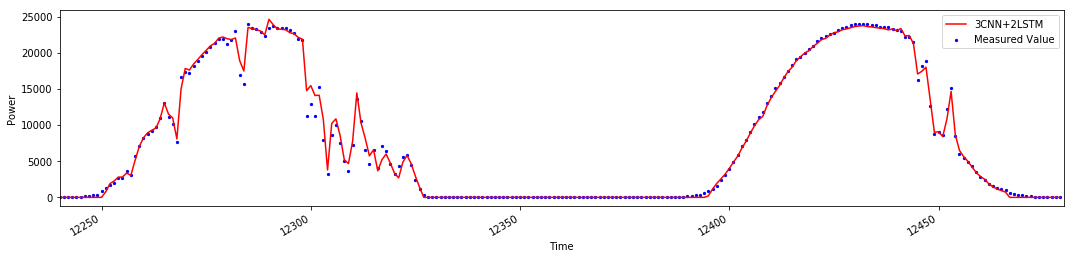

In [14]:
X = df.drop('Pa1', axis=1)
#y = df['Pa1']

xplot_min = 12240
xplot_max = 12480

fig, axes = plt.subplots(figsize=(18, 4))
axes.scatter(X.index[xplot_min:xplot_max],y[xplot_min:xplot_max],color="blue",label="Measured Value",s=5)
axes.plot(X.index[xplot_min:xplot_max],scores_predict_denorm[xplot_min:xplot_max], color="red",label="3CNN+2LSTM")
axes.legend()
axes.set_xlim(X.index[xplot_min],X.index[xplot_max])
axes.set_xlabel('Time')
axes.set_ylabel('Power')  


fig.autofmt_xdate()
plt.show()